In [36]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

In [37]:
# define schema
from pydantic import BaseModel, Field
class MoodSchema(BaseModel):
    mood: Literal["happy", "sad", "formal"] = Field(description="captures the tone of the users message")

In [38]:
from dotenv import load_dotenv
load_dotenv()

True

In [39]:
# bring in the llm
from langchain.chat_models import init_chat_model

#llm = init_chat_model("openai:gpt-4.1")
llm = init_chat_model("anthropic:claude-3-5-sonnet-latest")


In [48]:
def moodDetector(state: State)-> Literal["happy", "sad", "formal"]:
    llm_mood_detect = llm.with_structured_output(MoodSchema)
    mood = llm_mood_detect.invoke(state["messages"][-1].content)
    return mood.mood

In [49]:
def happyFun(state: State):
    print("You are happy")
    return {"messages": [llm.invoke(state["messages"])]}

def sadFun(state: State):
    print("You are Sad")
    return {"messages": [llm.invoke(state["messages"])]}

def formalFun(state: State):
    print("You are formal")
    return {"messages": [llm.invoke(state["messages"])]}
    

In [50]:
graph_builder = StateGraph(State)

#graph_builder.add_node("moodedetector", moodDetector)
graph_builder.add_node("happy",happyFun)
graph_builder.add_node("sad",sadFun)
graph_builder.add_node("formal",formalFun)

#graph_builder.add_edge(START, "moodedetector")
graph_builder.add_conditional_edges(START,moodDetector)
graph_builder.add_edge("happy", END)
graph_builder.add_edge("sad", END)
graph_builder.add_edge("formal", END)
graph = graph_builder.compile()



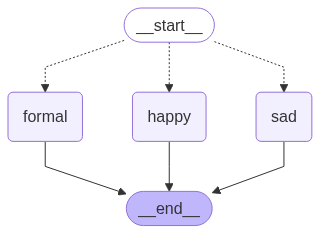

In [51]:
# view the graph

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [54]:
# simple run

state = {
    "messages" : [
        {
            "role": "user",
            "content": "Man, I am having the time of my life"
        }
    ]
}
state = graph.invoke(state)
state

You are happy


{'messages': [HumanMessage(content='Man, I am having the time of my life', additional_kwargs={}, response_metadata={}, id='911fd5ff-4ef1-43e8-8eac-c3c0b962267f'),
  AIMessage(content="That's great to hear! What's making life so enjoyable for you right now?", additional_kwargs={}, response_metadata={'id': 'msg_01WfLb2paRAodexVhnsqPUtF', 'model': 'claude-3-5-sonnet-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 17, 'output_tokens': 21, 'server_tool_use': None, 'service_tier': 'standard'}, 'model_name': 'claude-3-5-sonnet-20241022'}, id='run--2c413fd2-53eb-4eb5-8371-51999e52c571-0', usage_metadata={'input_tokens': 17, 'output_tokens': 21, 'total_tokens': 38, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})]}